# Part 1 项目介绍

## 1.1 项目背景

**CIFAR-10** (Canadian Institute For Advanced Research) 是计算机视觉领域中最广泛使用的基准数据集之一，由 Alex Krizhevsky, Vinod Nair 和 Geoffrey Hinton 收集整理。该数据集包含 60,000 张 32x32 分辨率的彩色 RGB 图像，分为训练集 50,000 张和测试集 10,000 张。数据集共包含 10 个互斥的类别，每个类别有 6,000 张图像。这 10 个类别分别是飞机 (airplane)、汽车 (automobile)、鸟 (bird)、猫 (cat)、鹿 (deer)、狗 (dog)、青蛙 (frog)、马 (horse)、船 (ship) 和卡车 (truck)。由于图像分辨率较低，对于人类来说有时也难以区分，这使得它成为测试图像分类算法性能的理想数据集。

## 1.2 项目目标

本项目旨在深入探究和对比**传统机器学习方法**与现代**深度学习方法**在图像分类任务上的性能差异，从而理解计算机视觉技术的发展脉络。

首先，我们将建立一个基于传统方法的基准模型。这包括构建一个经典的图像分类流水线，使用 **HOG (方向梯度直方图)** 提取图像的纹理和形状特征，利用 **PCA (主成分分析)** 进行降维以减少计算量并去除噪声，最后使用 **SVM (支持向量机)** 作为分类器进行训练和预测。

其次，我们将探索作为当前最先进技术（SOTA）方向的深度学习方法。我们将构建一个端到端的 **卷积神经网络 (CNN)** 模型，利用卷积层自动学习从边缘到纹理再到物体部件的图像层级特征，并对比不同网络结构或超参数对性能的影响。

最后，我们将对两种方法进行全面的对比分析。我们将比较它们在测试集上的最终分类准确率，分析训练时间和推理时间的效率差异，并通过 t-SNE 可视化特征分布来直观展示特征提取的效果，从而深入理解深度学习相比传统方法的优势所在。

## 1.3 技术路线

本项目的实施将分为三个主要阶段，涵盖了从数据预处理到模型评估的完整流程。

**Step 1: 特征提取与可视化**。我们将首先进行数据的加载与归一化预处理，接着提取图像的 HOG 特征。随后，利用 PCA 将高维特征进行降维，其中保留 95% 方差的特征用于后续训练，而降至 2-3 维的特征则结合 t-SNE 算法进行数据分布的可视化分析，以观察类别的可分性。

**Step 2: 传统模型实验**。我们将基于 PCA 降维后的 HOG 特征来训练 SVM 分类器。在此过程中，我们将使用网格搜索或交叉验证等方法来寻找如 C 和 gamma 等最佳超参数，并最终评估 SVM 模型的准确率和混淆矩阵等性能指标。

**Step 3: 深度模型实验**。我们将搭建包含卷积层、池化层和全连接层的 CNN 网络架构，并配置交叉熵损失函数以及 Adam 或 SGD 优化器等训练策略。通过监控训练集与验证集的损失和准确率曲线来训练模型，最终评估 CNN 模型的表现，并将其与 SVM 的结果进行总结对比。

## 1.4 补充说明

我们使用Kaggle上的比赛数据集 [链接](https://www.kaggle.com/competitions/cifar-10/data?select=trainLabels.csv)，所有模型的结果将会在Kaggle上提交以获得实时分数反馈

**参考资料**：
1. [一文讲解方向梯度直方图（hog）](https://zhuanlan.zhihu.com/p/85829145)
2. [t-sne算法详解](https://blog.csdn.net/qq_44015059/article/details/106675444)

# Part 2 特征提取和降维

本部分将提取图像的HOG特征并进行降维处理，为后续的传统机器学习模型做准备。

## 2.1 特征提取

### 2.1.1 HOG特征介绍

**HOG (Histogram of Oriented Gradients)**，即方向梯度直方图，是一种在计算机视觉和图像处理中广泛使用的特征描述子，特别适用于物体检测任务。它通过计算和统计图像局部区域的梯度方向直方图来构成特征，能够很好地描述图像的边缘和形状信息。

HOG特征提取的核心思想在于，局部目标的表象和形状能够被梯度或边缘的方向密度分布很好地描述。首先，我们需要计算图像中每个像素点的梯度。对于图像 $I$ 中的像素点 $(x,y)$，其水平方向梯度 $G_x$ 和垂直方向梯度 $G_y$ 可以通过中心差分算子计算得到：

$$ G_x(x,y) = I(x+1, y) - I(x-1, y) $$
$$ G_y(x,y) = I(x, y+1) - I(x, y-1) $$

基于这两个分量，我们可以进一步计算该像素点的梯度幅值 $G(x,y)$ 和梯度方向 $\theta(x,y)$：

$$ G(x,y) = \sqrt{G_x(x,y)^2 + G_y(x,y)^2} $$
$$ \theta(x,y) = \arctan\left(\frac{G_y(x,y)}{G_x(x,y)}\right) $$

在获得像素级的梯度信息后，我们将图像划分为若干个小的空间区域，称为“单元格” (Cell)。在每个单元格内，我们统计梯度方向的直方图，将梯度方向分为若干个区间 (Bin)，并将像素的梯度幅值作为权重累加到对应的方向区间中。为了消除光照和阴影变化的影响，我们通常会将几个相邻的单元格组合成一个更大的“块” (Block)，并在块的范围内对特征向量进行归一化处理。

HOG特征具有显著的优点。由于它是基于局部梯度的统计信息，因此对图像的几何和光学形变保持了较好的不变性。特别是通过块归一化操作，它对光照变化表现出较强的鲁棒性，能够有效地捕捉物体的边缘轮廓信息，忽略无关的颜色或纹理细节。

我们在本次实验选择提取HOG特征，是因为HOG相比于其它的传统特征提取方法，更适合用于CIFAR任务中。这是由CIFAR图像的特点决定的。

**参数设置**:
- `orientations=9`: 梯度方向被分为9个bin
- `pixels_per_cell=(8, 8)`: 每个单元格为8x8像素
- `cells_per_block=(2, 2)`: 每个块包含2x2个单元格

如果需要找到最佳的参数提取组合，可能需要选择多种不同的参数。因为我们的传统方法主要作baseline使用，因此这里就尝试了一种组合

### 2.1.2 提取HOG特征

首先导入本部分必要的库(后续工作可以避免重复导入，仅导入新增的即可)

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from skimage.feature import hog
from skimage import color
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42) # 设置随机种子以确保结果可复现

然后，我们简单地查看一下数据的类别分布等特征，并且挑选10条数据进行查看

In [2]:
# 加载训练数据标签
data_dir = 'Data/cifar-10' # 数据目录路径, 如果没有需要下载！
train_labels_df = pd.read_csv(os.path.join(data_dir, 'trainLabels.csv'))

print(f"训练集样本数: {len(train_labels_df)}")
print(f"类别分布:")
print(train_labels_df['label'].value_counts())
print(f"查看前5行数据:")
print(train_labels_df.head())

训练集样本数: 50000
类别分布:
label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64
查看前5行数据:
   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile


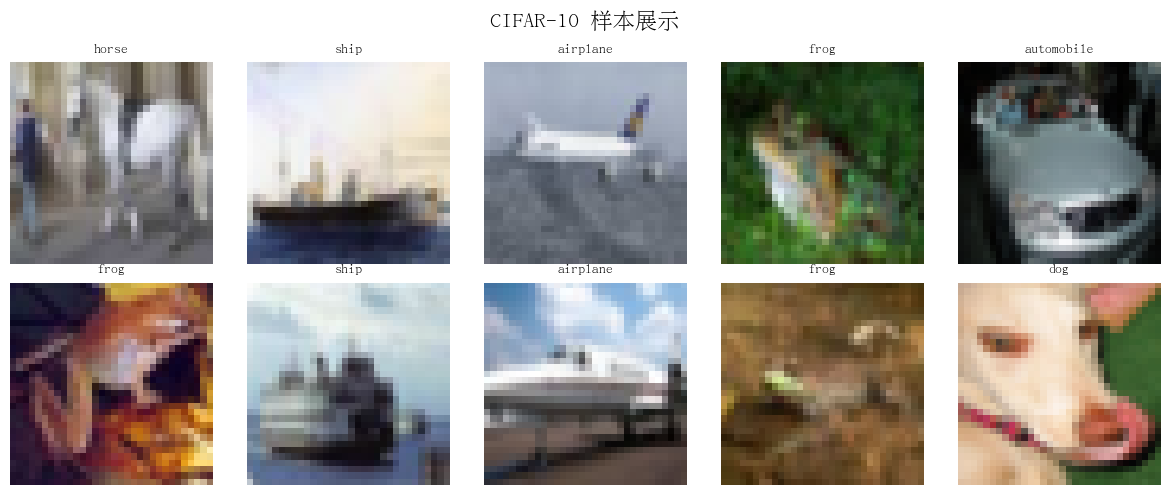

In [3]:
# 可视化部分样本
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('CIFAR-10 样本展示', fontsize=16)

# 随机选择10个样本
sample_ids = np.random.choice(train_labels_df['id'].values, 10, replace=False)

for idx, (ax, img_id) in enumerate(zip(axes.flatten(), sample_ids)):
    img_path = os.path.join(data_dir, 'train', f'{img_id}.png')
    img = Image.open(img_path)
    label = train_labels_df[train_labels_df['id'] == img_id]['label'].values[0]
    
    ax.imshow(img)
    ax.set_title(f'{label}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

下面这一部分，我们需要开始提取HOG特征。这一部分可以通过调用`skimage`包中的`hog()`函数实现

需要注意的是，因为原始图像是3通道的RGB图，我们需要先将图像转换为灰度图，再进行**HOG特征**提取

In [4]:
# 定义HOG特征提取函数
def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    提取图像的HOG特征
    
    参数:
        image: RGB图像 (H, W, 3)
        orientations: 梯度方向的bin数量
        pixels_per_cell: 每个cell的像素大小
        cells_per_block: 每个block包含的cell数量
    
    返回:
        hog_features: HOG特征向量
    """
    # 将RGB图像转换为灰度图
    if len(image.shape) == 3:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image
    
    # 提取HOG特征
    hog_features = hog(gray_image, 
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       visualize=False,
                       feature_vector=True)
    
    return hog_features

# 测试HOG特征提取
test_img_path = os.path.join(data_dir, 'train', '1.png')
test_img = np.array(Image.open(test_img_path))
test_hog = extract_hog_features(test_img)

print(f"原始图像形状: {test_img.shape}")
print(f"HOG特征维度: {test_hog.shape}")
print(f"HOG特征前10个值: {test_hog[:10]}")

原始图像形状: (32, 32, 3)
HOG特征维度: (324,)
HOG特征前10个值: [0.22663771 0.17619404 0.28460026 0.09246575 0.19104824 0.04217484
 0.00867563 0.03490412 0.0623346  0.14866002]


In [ ]:
# 批量提取HOG特征
n_samples = 50000 # 这里直接用所有的样本

print(f"开始提取 {n_samples} 个样本的HOG特征...")

hog_features_list = []
labels_list = []

for i in range(n_samples):
    if (i + 1) % 5000 == 0:
        print(f"已处理: {i + 1}/{n_samples}")
    
    # 获取图像ID和标签
    img_id = train_labels_df.iloc[i]['id']
    label = train_labels_df.iloc[i]['label']
    
    # 加载图像
    img_path = os.path.join(data_dir, 'train', f'{img_id}.png')
    img = np.array(Image.open(img_path))
    
    # 提取HOG特征
    hog_feat = extract_hog_features(img)
    
    hog_features_list.append(hog_feat)
    labels_list.append(label)

# 转换为numpy数组
X_hog = np.array(hog_features_list)
y = np.array(labels_list)

print(f"特征提取完成!")
print(f"HOG特征矩阵形状: {X_hog.shape}")
print(f"标签数组形状: {y.shape}")
print(f"类别分布:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count}")

开始提取 50000 个样本的HOG特征...


## 2.2 降维

本部分使用**PCA**进行降维,然后使用**t-SNE**进行可视化。可视化将会使用PCA降维到50维的预处理数据

### 2.2.1 PCA和t-SNE介绍

#### PCA (主成分分析)

**PCA (Principal Component Analysis)** 是一种经典的降维技术,通过线性变换将高维数据投影到低维空间。

**基本原理**:
1. 计算数据的协方差矩阵
2. 求解协方差矩阵的特征值和特征向量
3. 选择最大的k个特征值对应的特征向量
4. 将数据投影到这k个特征向量张成的空间

**优点**:
- 计算效率高
- 能够保留数据的主要方差信息
- 去除数据冗余和噪声

**应用**:
- 第一次降维:将HOG特征降到50维,用于t-SNE可视化
- 第二次降维:保留95%的方差,用于SVM分类

#### t-SNE (t分布随机邻域嵌入)

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** 是一种非线性降维算法,特别适合高维数据的可视化。

**基本原理**:
1. 在高维空间中,计算样本点之间的相似度
2. 在低维空间中,寻找一个映射使得点之间的相似度分布尽可能接近高维空间
3. 使用t分布来建模低维空间中的相似度

**优点**:
- 能够很好地保持数据的局部结构
- 适合将高维数据可视化到2D或3D空间
- 能够揭示数据的聚类结构

**注意**:
- 计算开销较大,通常先用PCA降维再使用t-SNE
- 结果受随机初始化影响,需要设置随机种子

### 2.2.2 PCA降维

第一部分降维，需要将原始维度压缩到50维，然后用于t-SNE可视化

第二部分降维，需要将原始数据的信息保留$95\%$左右，然后用于Part 3 的SVM

第一次PCA降维: 降到50维 (用于t-SNE可视化)

降维后的形状: (10000, 50)
保留的总方差比例: 0.7327 (73.27%)
前10个主成分的方差比例: [0.09908627 0.04978861 0.03567527 0.03091203 0.02940392 0.02654681
 0.02253222 0.02192762 0.02077377 0.02064413]


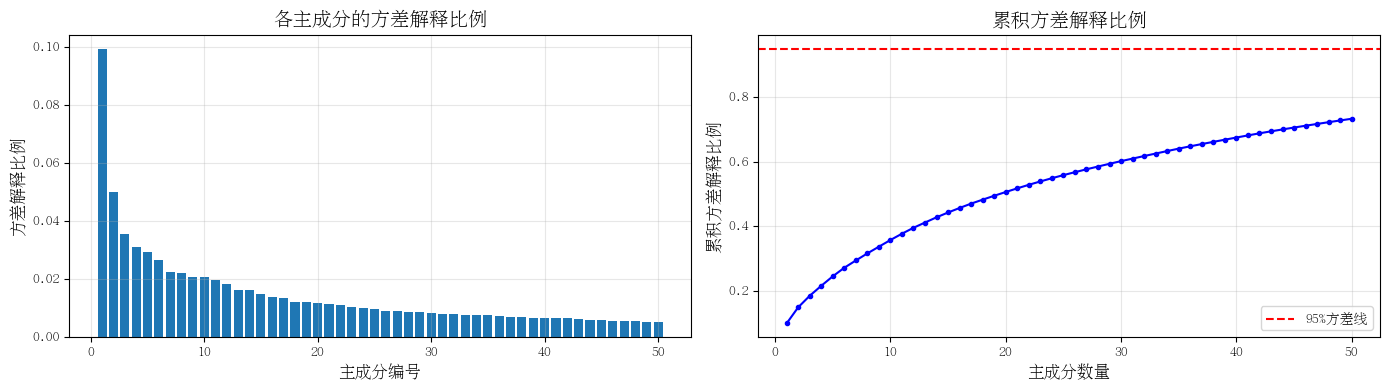

In [ ]:
# 第一次PCA降维: 降到50维,用于t-SNE可视化
print("=" * 60)
print("第一次PCA降维: 降到50维 (用于t-SNE可视化)")
print("=" * 60)

pca_50 = PCA(n_components=50, random_state=42)
X_pca_50 = pca_50.fit_transform(X_hog)

# 计算解释的方差比例
explained_variance_ratio_50 = pca_50.explained_variance_ratio_
cumulative_variance_ratio_50 = np.cumsum(explained_variance_ratio_50)

print(f"\n降维后的形状: {X_pca_50.shape}")
print(f"保留的总方差比例: {cumulative_variance_ratio_50[-1]:.4f} ({cumulative_variance_ratio_50[-1]*100:.2f}%)")
print(f"前10个主成分的方差比例: {explained_variance_ratio_50[:10]}")

# 可视化方差解释比例
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# 单个主成分的方差比例
ax1.bar(range(1, 51), explained_variance_ratio_50)
ax1.set_xlabel('主成分编号')
ax1.set_ylabel('方差解释比例')
ax1.set_title('各主成分的方差解释比例')
ax1.grid(True, alpha=0.3)

# 累积方差解释比例
ax2.plot(range(1, 51), cumulative_variance_ratio_50, 'b-', marker='o', markersize=3)
ax2.set_xlabel('主成分数量')
ax2.set_ylabel('累积方差解释比例')
ax2.set_title('累积方差解释比例')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95%方差线')
ax2.legend()

plt.tight_layout()
plt.show()


第二次PCA降维: 保留95%的方差 (用于SVM分类)

降维后的维度: 118
降维后的形状: (10000, 118)
保留的总方差比例: 0.9503 (95.03%)
维度压缩率: 0.3642 (36.42%)


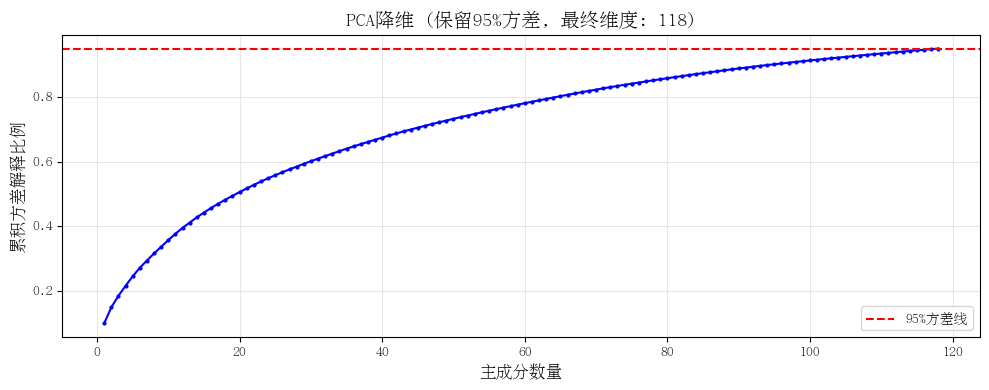


✓ PCA降维完成,数据已准备好用于后续的SVM分类器训练


In [ ]:
# 第二次PCA降维: 保留95%的方差,用于SVM分类
print("\n" + "=" * 60)
print("第二次PCA降维: 保留95%的方差 (用于SVM分类)")
print("=" * 60)

pca_95 = PCA(n_components=0.95, random_state=42)
X_pca_95 = pca_95.fit_transform(X_hog)

# 计算解释的方差比例
explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_ratio_95 = np.cumsum(explained_variance_ratio_95)

print(f"\n降维后的维度: {X_pca_95.shape[1]}")
print(f"降维后的形状: {X_pca_95.shape}")
print(f"保留的总方差比例: {cumulative_variance_ratio_95[-1]:.4f} ({cumulative_variance_ratio_95[-1]*100:.2f}%)")
print(f"维度压缩率: {X_pca_95.shape[1] / X_hog.shape[1]:.4f} ({X_pca_95.shape[1] / X_hog.shape[1] * 100:.2f}%)")

# 可视化
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(1, len(cumulative_variance_ratio_95) + 1), cumulative_variance_ratio_95, 'b-', marker='o', markersize=2)
ax.set_xlabel('主成分数量')
ax.set_ylabel('累积方差解释比例')
ax.set_title(f'PCA降维 (保留95%方差, 最终维度: {X_pca_95.shape[1]})')
ax.grid(True, alpha=0.3)
ax.axhline(y=0.95, color='r', linestyle='--', label='95%方差线')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\n✓ PCA降维完成,数据已准备好用于后续的SVM分类器训练")

### 2.2.3 t-SNE可视化

In [ ]:
# 使用t-SNE将50维数据降到2维进行可视化
print("=" * 60)
print("t-SNE降维可视化")
print("=" * 60)
print("\n注意: t-SNE计算可能需要几分钟时间...")

# 为了加速演示,我们可以使用部分数据进行t-SNE可视化
# 完整实验可以使用全部数据
n_tsne_samples = 5000  # 使用5000个样本进行t-SNE可视化

# 随机选择样本
np.random.seed(42)
indices = np.random.choice(len(X_pca_50), n_tsne_samples, replace=False)
X_tsne_input = X_pca_50[indices]
y_tsne = y[indices]

print(f"使用 {n_tsne_samples} 个样本进行t-SNE可视化")
print(f"输入数据形状: {X_tsne_input.shape}")

# 应用t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_tsne_input)

print(f"t-SNE降维后的形状: {X_tsne.shape}")
print("✓ t-SNE降维完成")

t-SNE降维可视化

注意: t-SNE计算可能需要几分钟时间...
使用 5000 个样本进行t-SNE可视化
输入数据形状: (5000, 50)
t-SNE降维后的形状: (5000, 2)
✓ t-SNE降维完成
t-SNE降维后的形状: (5000, 2)
✓ t-SNE降维完成


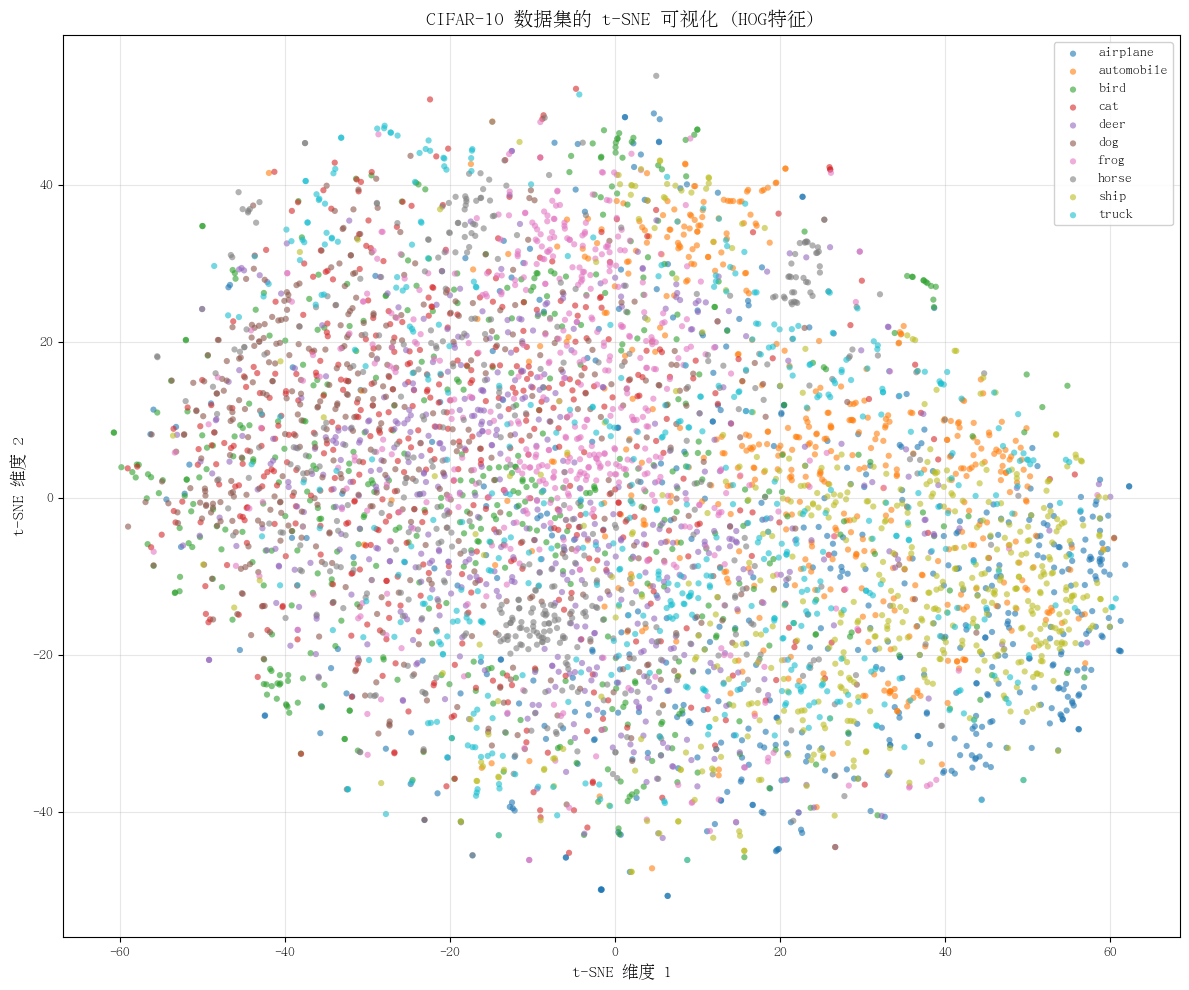


✓ t-SNE可视化完成

从可视化结果可以看出:
- 不同类别的样本在2维空间中形成了一定的聚类
- 某些类别(如交通工具类)可能会有一定的重叠
- HOG特征能够在一定程度上区分不同的图像类别


In [ ]:
# 可视化t-SNE结果
fig, ax = plt.subplots(figsize=(12, 10))

# 定义颜色映射
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']
colors = plt.cm.tab10(np.linspace(0, 1, 10))
class_to_color = {cls: colors[i] for i, cls in enumerate(classes)}

# 绘制每个类别
for cls in classes:
    mask = y_tsne == cls
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
              c=[class_to_color[cls]], 
              label=cls, 
              alpha=0.6, 
              s=20,
              edgecolors='none')

ax.set_xlabel('t-SNE 维度 1', fontsize=12)
ax.set_ylabel('t-SNE 维度 2', fontsize=12)
ax.set_title('CIFAR-10 数据集的 t-SNE 可视化 (HOG特征)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ t-SNE可视化完成")
print("\n从可视化结果可以看出:")
print("- 不同类别的样本在2维空间中形成了一定的聚类")
print("- 某些类别(如交通工具类)可能会有一定的重叠")
print("- HOG特征能够在一定程度上区分不同的图像类别")

# Part 3 传统模型实验

# Part 4 深度模型实验

# Part 5 总结